In [1]:
import geopandas as gpd
import pandas as pd
import psycopg2

from shapely.geometry import Point

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import datetime
import matplotlib.units as munits


def date_format(ax):
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    ax.xaxis.set_tick_params(pad = 4, labelsize = 14, which = "major", rotation = 0)
    ax.xaxis.set_tick_params(pad = 4, labelsize = 10, which = "minor", rotation = 0)
    
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center", rotation_mode="anchor")

    
from netrc import netrc

user, acct, passwd = netrc().authenticators("census")
cen_con = psycopg2.connect(database = "census", user = user, password = passwd,
                           host = "localhost", port = 5434)

In [23]:
# Tract geometries from 2018 ACS.
us4326 = gpd.read_postgis("SELECT geoid, ST_Transform(geomsimp, 4326) geom FROM census_tracts_2018;",
                          con = cen_con, geom_col = "geom", crs = "EPSG:4326")

# Get basic demographics from 2017 ACS.
prof17 = pd.read_sql("SELECT geoid, log_mhi, black, total_pop FROM acsprofile5y2017;", con = cen_con)

## Construct rank & categories for median household income.
prof17["mhi_rank"] = prof17.log_mhi.rank() / prof17.shape[0]
prof17["mhi_class"] = "mid"
prof17.loc[prof17.mhi_rank < 0.25, "mhi_class"] = "low"
prof17.loc[prof17.mhi_rank > 0.75, "mhi_class"] = "high"

# Read in the SamKnows location data.
sk = pd.read_excel("sk_sept2018.xlsx", engine = "openpyxl")
sk.rename(columns = {"unit id" : "unit_id"}, inplace = True)

print("tract or blockgroup:", sk.geog_type.isin(["blockgroup", "tract"]).mean())

sk.query("(geog_type == 'blockgroup') | (geog_type == 'tract')", inplace = True)

## Transform this into a GeoDataFrame since the GEOIDs are busted.
geo_sk = gpd.GeoSeries([Point(xy) for xy in sk[["longitude", "latitude"]].values], 
                       index = sk.index, crs = "EPSG:4326")

geo_sk = gpd.GeoDataFrame(data = sk, geometry = geo_sk, crs = "EPSG:4326")

## Merge these together.
sk_tr18 = gpd.sjoin(geo_sk, us4326, op = "within")[["unit_id", "geoid"]]
sk_tr18 = sk_tr18.sort_values("unit_id").reset_index(drop = True)
sk_tr18 = sk_tr18.sort_values("unit_id")


# Check that we're not losing data by merging 2018 and 2017 profile data.
assert(pd.merge(sk_tr18, prof17).shape[0] == sk_tr18.shape[0])

sk_tr18 = pd.merge(sk_tr18, prof17)

tract or blockgroup: 0.9404911838790933


### Retrieve and cache SamKnows data from the database.

In [3]:
usage_sql = """
SELECT 
  unit_id, dtime::DATE dtime, 
  SUM(cust_wired_tx_bytes / 1e9) wired_tx_gb, 
  SUM(cust_wired_rx_bytes / 1e9) wired_rx_gb, 
  SUM(cust_wifi_tx_bytes  / 1e9) wifi_tx_gb, 
  SUM(cust_wifi_rx_bytes  / 1e9) wifi_rx_gb,
  SUM(cust_wired_tx_bytes / 1e9 + cust_wifi_tx_bytes / 1e9) tx_gb, 
  SUM(cust_wired_rx_bytes / 1e9 + cust_wifi_rx_bytes / 1e9) rx_gb
FROM datausage 
WHERE 
  dtime::DATE != '2020-02-07'
GROUP BY unit_id, dtime::DATE
HAVING
  SUM(cust_wired_tx_bytes / 1e9 + cust_wifi_tx_bytes/ 1e9) < 1000
ORDER BY unit_id, dtime::DATE
"""

speed_sql = """
SELECT
  unit_id, dtime::DATE,
  AVG(bytes_sec / 125000) speed
FROM httpgetmt 
WHERE 
  dtime::DATE != '2020-02-07' AND
  successes != 0 AND sequence < 5 AND
  (target LIKE '%mlab%' OR target LIKE '%level3%') AND 
  address != '0'
GROUP BY unit_id, dtime::DATE
ORDER BY unit_id, dtime::DATE
"""


def retrieve_sk_data():
    
    user, acct, passwd = netrc().authenticators("sk")
    
    sk_con = psycopg2.connect(database = "sk", user = user, password = passwd,
                          host = "localhost", port = 5433)

    usage = pd.read_sql(usage_sql, con = sk_con)
    usage.to_csv("sk_usage.csv.gz", index = False, header = True)
    
    httpgetmt = pd.read_sql(speed_sql, con = sk_con)
    httpgetmt.to_csv("sk_httpgetmt.csv.gz", index = False, header = True)

# retrieve_sk_data()

### Consumption

In [4]:
usage = pd.read_csv("sk_usage.csv.gz")
usage["date"] = pd.to_datetime(usage.dtime)
usage = usage.merge(sk_tr18, on = "unit_id")

usage_quantiles = usage.groupby(["date", "mhi_class"])[["tx_gb", "rx_gb"]].quantile([0.25, 0.50, 0.75, 0.9])
usage_quantiles = usage_quantiles.unstack().unstack().swaplevel(i = 1, j = 2, axis = 1)

Plot defaults

In [13]:
colors = {"low" : "#00FF88", "mid" : "#0088FF", "high" : "#FF00FF"}
ls = {0.25 : ":", 0.5 : "-", 0.75 : ":"}
lw = {0.25 : 0.4, 0.5 : 1.5, 0.75 : 0.4, 0.9: 0.4}
label = {"mid" : "Middle", "low" : "Lower", "high" : "Upper"}
ylabel = {"rx_gb" : "Received [GB/day]", "tx_gb" : "Transmitted [GB/day]"}
xlim = ("2019-11-01", "2020-08-01")

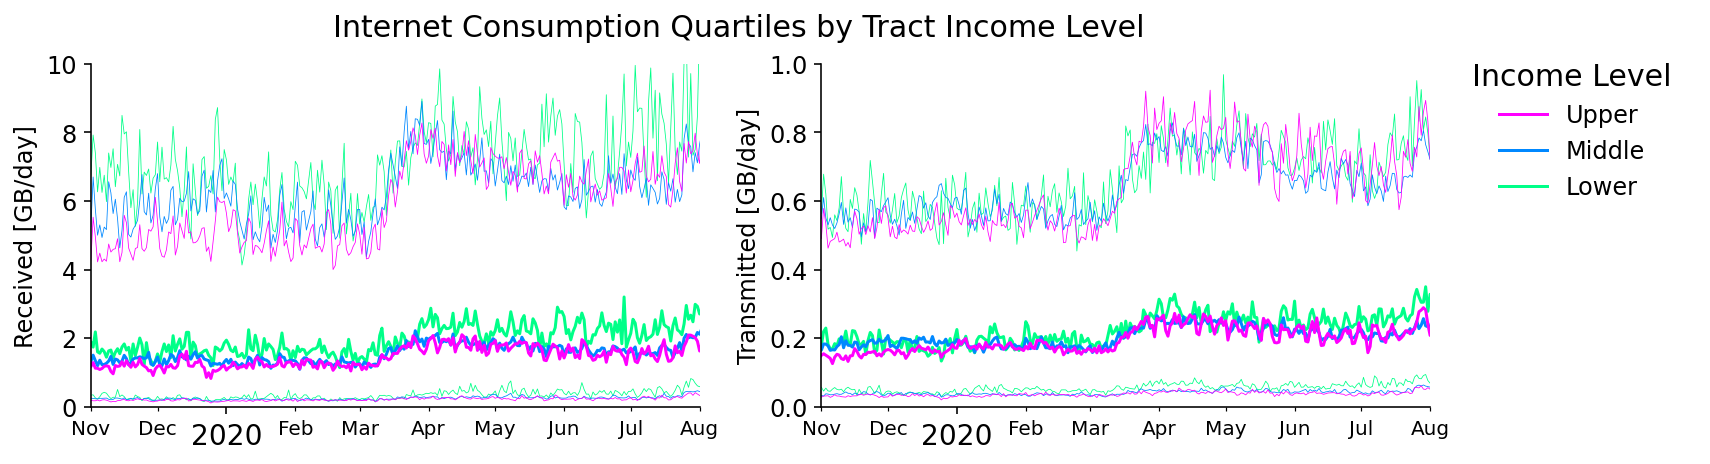

In [25]:
fig, ax = plt.subplots(1, 2, figsize = (12, 3.5), sharex = True)

for axi, v in zip(ax, ["rx_gb", "tx_gb"]):
    for mhi in ["low", "mid", "high"]:
        for q in [0.25, 0.5, 0.75]:

            l = label[mhi] if (q == 0.5 and v == "tx_gb") else "_"

            usage_quantiles[v][mhi][q].plot(color = colors[mhi], linewidth = lw[q],
                                            ax = axi, label = l)
            
    axi.set_xlabel("")
    axi.set_ylabel(ylabel[v])
    
    axi.set_xlim(xlim)
    
    date_format(axi)
        
h, l = axi.get_legend_handles_labels()

leg = axi.legend(h[::-1], l[::-1])
leg.set_title("Income Level", prop = {"size" : 15})
leg.set_bbox_to_anchor((1.01, 0.5))

ax[0].set_ylim(0, 10)
ax[1].set_ylim(0, 1)

fig.suptitle("Internet Consumption Quartiles by Tract Income Level", fontsize = 15)

fig.savefig("../figs/sk_consumption.pdf")

### Bandwidth.

In [15]:
httpgetmt = pd.read_csv("sk_httpgetmt.csv.gz")
httpgetmt["date"]  = pd.to_datetime(httpgetmt.dtime)
httpgetmt = httpgetmt.merge(sk_tr18, on = "unit_id")

speed_quantiles = httpgetmt.groupby(["date", "mhi_class"]).speed.quantile([0.25, 0.50, 0.75, 0.9])
speed_quantiles = speed_quantiles.unstack().unstack().swaplevel(i = 0, j = 1, axis = 1)

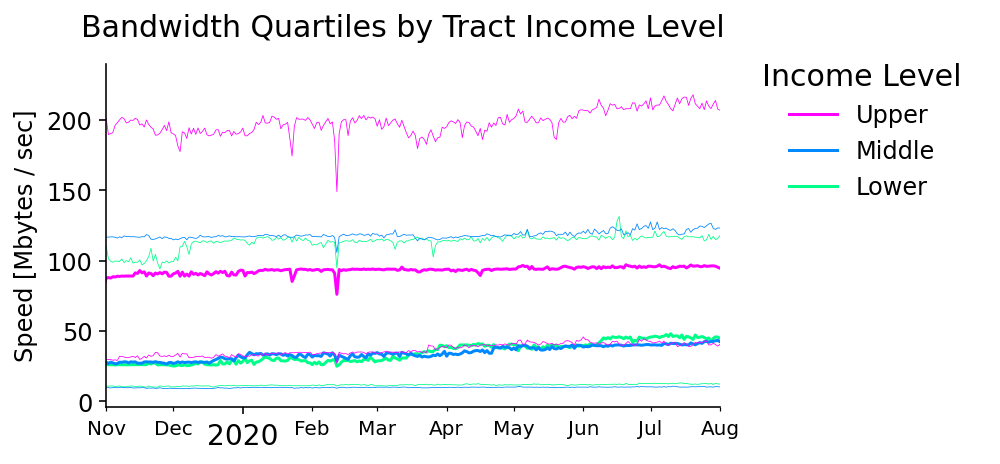

In [16]:
fig, ax = plt.subplots(figsize = (5.5, 3.5))

for mhi in ["low", "mid", "high"]:
    for q in [0.25, 0.5, 0.75]:

        l = label[mhi] if (q == 0.5) else "_"

        speed_quantiles[mhi][q].plot(color = colors[mhi], linewidth = lw[q],
                                     ax = ax, label = l)

ax.set_xlabel("")
ax.set_ylabel("Speed [Mbytes / sec]")

ax.set_xlim(xlim)

date_format(ax)
        
h, l = ax.get_legend_handles_labels()

leg = ax.legend(h[::-1], l[::-1])
leg.set_title("Income Level", prop = {"size" : 15})
leg.set_bbox_to_anchor((1.01, 0.5))

fig.suptitle("Bandwidth Quartiles by Tract Income Level", fontsize = 15)

fig.savefig("../figs/sk_bandwidth.pdf")